Commandes pour installer les packages nécessaires dans l'environnement virtuel:

In [10]:
import sys
#!{sys.executable} -m pip install --upgrade pip
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install scikit-image
#!{sys.executable} -m pip install scikit-learn
#!{sys.executable} -m pip install pillow
#!{sys.executable} -m pip install SimpleITK
#!{sys.executable} -m pip install opencv-python
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install qtconsole
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install pydot
#!{sys.executable} -m pip install graphviz
#!pip install PyDrive

! pip install kaggle
! pip install nvidia-smi
! gdown --id 11dzPv9LxegCDJTNE0RVCJD9hi2sxjQb4
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d 'moulhanout/stanford-dogs-dataset'
! unzip stanford-dogs-dataset
!{sys.executable} -m pip install tensorflow_addons
!pip install --quiet vit-keras

#! kaggle datasets list -s 'Stanford Dogs'
#! pip install --upgrade --force-reinstall --no-deps kaggle

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1357.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1367.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13839.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13898.jpg  
  inflating: image

Import des librairies

In [15]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
import tensorflow_addons as tfa
from keras import layers, Input
from keras.layers import Dense, InputLayer, Flatten
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import scipy.io
from PIL import Image, ImageOps
import time
from keras.preprocessing.image import img_to_array, load_img
from bs4 import BeautifulSoup
import glob, warnings
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab import drive
from vit_keras import vit, utils,visualize
from keras.models import Model

drive.mount('/content/drive/')

Mounted at /content/drive/


Navigation vers le dossiers contenant les images et les libellés:

In [3]:
cd ../Formation_Ingenieur_Machine_Learning/P6_voelker_jean-florent

[Errno 2] No such file or directory: '../Formation_Ingenieur_Machine_Learning/P6_voelker_jean-florent'
/content


Je paramètre mes variables globales:

In [16]:
NB_CLASSES = 120
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
BATCH_SIZE = 8
NB_EPOCH = 100

DIRECTORY_TRAINED_MODEL = 'model_vit.hdf5'
COLOR_MODE = "rgb"

ANNOTATION_PATH = os.path.join("annotation/Annotation")
IMAGE_FOLDER_PATH = os.path.join("images/Images")

Je charge les fichiers .mat :

In [17]:
file_list = scipy.io.loadmat('lists/file_list.mat')
train_list = scipy.io.loadmat('lists/train_list.mat')
test_list = scipy.io.loadmat('lists/test_list.mat')

J'ai 20580 images dans le dataset

In [18]:
print(len(file_list['file_list']))

20580


Je créé un DataFrame avec tous les noms d'image et toutes les classes d'image comme variables:

In [19]:
FileList_df=pd.DataFrame()
FileList_df[['NomImage']]=file_list['file_list']
FileList_df[['ClasseImage']]=file_list['labels']
FileList_df[['AnnotationList']]=file_list['annotation_list']
FileList_df

,NomImage,ClasseImage,AnnotationList
0,[n02085620-Chihuahua/n02085620_10074.jpg],1,[n02085620-Chihuahua/n02085620_10074]
1,[n02085620-Chihuahua/n02085620_10131.jpg],1,[n02085620-Chihuahua/n02085620_10131]
2,[n02085620-Chihuahua/n02085620_10621.jpg],1,[n02085620-Chihuahua/n02085620_10621]
3,[n02085620-Chihuahua/n02085620_1073.jpg],1,[n02085620-Chihuahua/n02085620_1073]
4,[n02085620-Chihuahua/n02085620_10976.jpg],1,[n02085620-Chihuahua/n02085620_10976]
...,...,...,...
20575,[n02116738-African_hunting_dog/n02116738_9798....,120,[n02116738-African_hunting_dog/n02116738_9798]
20576,[n02116738-African_hunting_dog/n02116738_9818....,120,[n02116738-African_hunting_dog/n02116738_9818]
20577,[n02116738-African_hunting_dog/n02116738_9829....,120,[n02116738-African_hunting_dog/n02116738_9829]
20578,[n02116738-African_hunting_dog/n02116738_9844....,120,[n02116738-African_hunting_dog/n02116738_9844]


In [20]:
TrainList_df=pd.DataFrame()
TrainList_df[['NomImage']]=train_list['file_list']
TrainList_df[['ClasseImage']]=train_list['labels']
TrainList_df

,NomImage,ClasseImage
0,[n02085620-Chihuahua/n02085620_5927.jpg],1
1,[n02085620-Chihuahua/n02085620_4441.jpg],1
2,[n02085620-Chihuahua/n02085620_1502.jpg],1
3,[n02085620-Chihuahua/n02085620_1916.jpg],1
4,[n02085620-Chihuahua/n02085620_13151.jpg],1
...,...,...
11995,[n02116738-African_hunting_dog/n02116738_10614...,120
11996,[n02116738-African_hunting_dog/n02116738_9282....,120
11997,[n02116738-African_hunting_dog/n02116738_6754....,120
11998,[n02116738-African_hunting_dog/n02116738_9333....,120


In [21]:
TestList_df=pd.DataFrame()
TestList_df[['NomImage']]=test_list['file_list']
TestList_df[['ClasseImage']]=test_list['labels']
TestList_df

,NomImage,ClasseImage
0,[n02085620-Chihuahua/n02085620_2650.jpg],1
1,[n02085620-Chihuahua/n02085620_4919.jpg],1
2,[n02085620-Chihuahua/n02085620_1765.jpg],1
3,[n02085620-Chihuahua/n02085620_3006.jpg],1
4,[n02085620-Chihuahua/n02085620_1492.jpg],1
...,...,...
8575,[n02116738-African_hunting_dog/n02116738_4991....,120
8576,[n02116738-African_hunting_dog/n02116738_3024....,120
8577,[n02116738-African_hunting_dog/n02116738_3635....,120
8578,[n02116738-African_hunting_dog/n02116738_2988....,120


Je modifie les colonnes "NomImage" de sorte à avoir accès directement à la valeur et non à un tableau à une valeur.

In [22]:
def getItemValue(x):
    return x[0]


FileList_df[['NomImage']]=FileList_df[['NomImage']].applymap(getItemValue)
FileList_df[['AnnotationList']]=FileList_df[['AnnotationList']].applymap(getItemValue)
print(FileList_df.head())

                                  NomImage  ClasseImage  \
0  n02085620-Chihuahua/n02085620_10074.jpg            1   
1  n02085620-Chihuahua/n02085620_10131.jpg            1   
2  n02085620-Chihuahua/n02085620_10621.jpg            1   
3   n02085620-Chihuahua/n02085620_1073.jpg            1   
4  n02085620-Chihuahua/n02085620_10976.jpg            1   

                        AnnotationList  
0  n02085620-Chihuahua/n02085620_10074  
1  n02085620-Chihuahua/n02085620_10131  
2  n02085620-Chihuahua/n02085620_10621  
3   n02085620-Chihuahua/n02085620_1073  
4  n02085620-Chihuahua/n02085620_10976  


In [23]:
TrainList_df[['NomImage']]=TrainList_df[['NomImage']].applymap(getItemValue)
print(TrainList_df.head())

                                  NomImage  ClasseImage
0   n02085620-Chihuahua/n02085620_5927.jpg            1
1   n02085620-Chihuahua/n02085620_4441.jpg            1
2   n02085620-Chihuahua/n02085620_1502.jpg            1
3   n02085620-Chihuahua/n02085620_1916.jpg            1
4  n02085620-Chihuahua/n02085620_13151.jpg            1


In [24]:
TestList_df[['NomImage']]=TestList_df[['NomImage']].applymap(getItemValue)
print(TestList_df.head())

                                 NomImage  ClasseImage
0  n02085620-Chihuahua/n02085620_2650.jpg            1
1  n02085620-Chihuahua/n02085620_4919.jpg            1
2  n02085620-Chihuahua/n02085620_1765.jpg            1
3  n02085620-Chihuahua/n02085620_3006.jpg            1
4  n02085620-Chihuahua/n02085620_1492.jpg            1


Je créé une fonction pour récupérer la le libellé de la race de chien

In [25]:
def getClassLibelle(x):
    classe_1 = x.split("/")
    classe_1 = classe_1[0]
    classe_2 = classe_1.split("-")
    return classe_2[1]

Je créé une colonne avec le libellé de la classe pour le dataframe TrainList_df 

In [26]:
TrainList_df[['ClasseImageLibelle']]=TrainList_df[['NomImage']].applymap(getClassLibelle)
TrainList_df

,NomImage,ClasseImage,ClasseImageLibelle
0,n02085620-Chihuahua/n02085620_5927.jpg,1,Chihuahua
1,n02085620-Chihuahua/n02085620_4441.jpg,1,Chihuahua
2,n02085620-Chihuahua/n02085620_1502.jpg,1,Chihuahua
3,n02085620-Chihuahua/n02085620_1916.jpg,1,Chihuahua
4,n02085620-Chihuahua/n02085620_13151.jpg,1,Chihuahua
...,...,...,...
11995,n02116738-African_hunting_dog/n02116738_10614.jpg,120,African_hunting_dog
11996,n02116738-African_hunting_dog/n02116738_9282.jpg,120,African_hunting_dog
11997,n02116738-African_hunting_dog/n02116738_6754.jpg,120,African_hunting_dog
11998,n02116738-African_hunting_dog/n02116738_9333.jpg,120,African_hunting_dog


J'affiche le nombre d'images d'entrainement par race de chien:

                                NomImage  ClasseImage
ClasseImageLibelle                                   
Afghan_hound                         100          100
African_hunting_dog                  100          100
Airedale                             100          100
American_Staffordshire_terrier       100          100
Appenzeller                          100          100
...                                  ...          ...
toy_poodle                           100          100
toy_terrier                          100          100
vizsla                               100          100
whippet                              100          100
wire                                 100          100

[120 rows x 2 columns]
NomImage       100.0
ClasseImage    100.0
dtype: float64
NomImage       100
ClasseImage    100
dtype: int64
NomImage       100
ClasseImage    100
dtype: int64


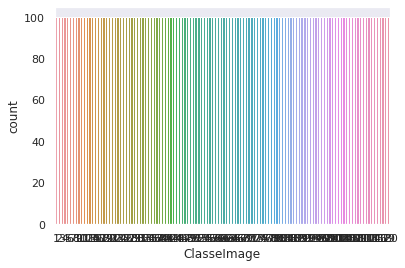

In [27]:
sns.set(style="darkgrid")
sns.countplot(x="ClasseImage", data=TrainList_df)
print(TrainList_df.groupby(['ClasseImageLibelle']).count())
print(TrainList_df.groupby(['ClasseImageLibelle']).count().mean())
print(TrainList_df.groupby(['ClasseImageLibelle']).count().min())
print(TrainList_df.groupby(['ClasseImageLibelle']).count().max())

J'ai 100 images par race de chien pour l'entraînement.

Je créé une colonne avec le libellé de la classe pour le dataframe TestList_df

In [28]:
TestList_df[['ClasseImageLibelle']]=TestList_df[['NomImage']].applymap(getClassLibelle)
TestList_df

,NomImage,ClasseImage,ClasseImageLibelle
0,n02085620-Chihuahua/n02085620_2650.jpg,1,Chihuahua
1,n02085620-Chihuahua/n02085620_4919.jpg,1,Chihuahua
2,n02085620-Chihuahua/n02085620_1765.jpg,1,Chihuahua
3,n02085620-Chihuahua/n02085620_3006.jpg,1,Chihuahua
4,n02085620-Chihuahua/n02085620_1492.jpg,1,Chihuahua
...,...,...,...
8575,n02116738-African_hunting_dog/n02116738_4991.jpg,120,African_hunting_dog
8576,n02116738-African_hunting_dog/n02116738_3024.jpg,120,African_hunting_dog
8577,n02116738-African_hunting_dog/n02116738_3635.jpg,120,African_hunting_dog
8578,n02116738-African_hunting_dog/n02116738_2988.jpg,120,African_hunting_dog


J'affiche le nombre d'images de test par race de chien:

                                NomImage  ClasseImage
ClasseImageLibelle                                   
Afghan_hound                         139          139
African_hunting_dog                   69           69
Airedale                             102          102
American_Staffordshire_terrier        64           64
Appenzeller                           51           51
...                                  ...          ...
toy_poodle                            51           51
toy_terrier                           72           72
vizsla                                54           54
whippet                               87           87
wire                                  57           57

[120 rows x 2 columns]
NomImage       71.5
ClasseImage    71.5
dtype: float64
NomImage       48
ClasseImage    48
dtype: int64
NomImage       152
ClasseImage    152
dtype: int64


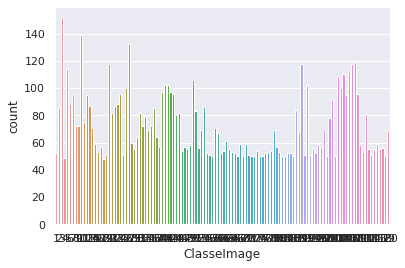

In [29]:
sns.set(style="darkgrid")
sns.countplot(x="ClasseImage", data=TestList_df)
print(TestList_df.groupby(['ClasseImageLibelle']).count())
print(TestList_df.groupby(['ClasseImageLibelle']).count().mean())
print(TestList_df.groupby(['ClasseImageLibelle']).count().min())
print(TestList_df.groupby(['ClasseImageLibelle']).count().max())

J'ai entre 48 et 152 images par race de chien pour la validation et le test.

Je charge une image

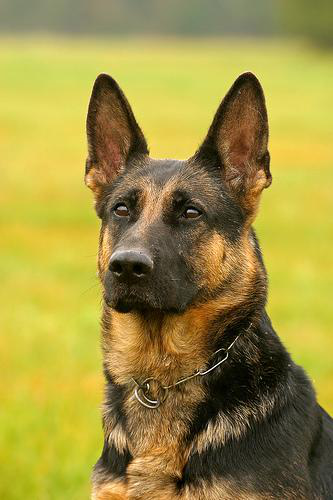

In [30]:
img = Image.open(os.path.join(IMAGE_FOLDER_PATH,TrainList_df['NomImage'][8400]))
display(img) 

Création d'une fonction pour éliminer les images corrompues ou qui n'existent pas:

In [31]:
def remove_corupted_files(DataFrame):
    num_skipped = 0
    num_absent = 0
    is_jfif = False
    for FileName in DataFrame['NomImage']:
        fpath = os.path.join(IMAGE_FOLDER_PATH, FileName)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            fobj.close()
        except:
            #retire une image qui n'existe pas
            #print(FileName)
            num_absent += 1
            DataFrame = DataFrame[DataFrame['NomImage']!=FileName]
            

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
            DataFrame = DataFrame[DataFrame['NomImage']!=FileName]

    print("Nombre images supprimées: %d" % num_skipped)
    print("Nombre images absentes: %d" % num_absent)
    return DataFrame

In [32]:
FileList_df_2 = remove_corupted_files(FileList_df)

Nombre images supprimées: 10
Nombre images absentes: 0


In [33]:
TrainList_df_2 = remove_corupted_files(TrainList_df)

Nombre images supprimées: 0
Nombre images absentes: 6


In [34]:
TestList_df_2 = remove_corupted_files(TestList_df)

Nombre images supprimées: 0
Nombre images absentes: 4


### Preprocessing des images

In [35]:
#ImageDataGenerator avec Data-augmentation
train_datagen_1 = ImageDataGenerator(
    rescale=1.0/255,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    channel_shift_range=0.1,
    rotation_range = 90,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range=[0.3,1.0]
)


#ImageDataGenerator sans Data-augmentation
train_datagen_2 = ImageDataGenerator(
    rescale=1.0/255,
)


#Image générateur pour lots de validation et de test
valid_datagen_1 = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.5,
)

Je dois fitter mes générateur d'images:

Je créé un tableau avec les images originelles

In [36]:
X_fitting = []
folder_path = os.path.join(IMAGE_FOLDER_PATH)
nb_image=0

#Début chronomètre
start = time.time()

#for imgPath in folder_path:
for FileName in TrainList_df_2['NomImage']:
    imgPath = os.path.join(folder_path, FileName)
    nb_image+=1
    
    try:
        img = cv2.imread(imgPath, -1)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        img = np.array(img, dtype="float")

        X_fitting.append(img)
    except:
        print(imgPath)


end = time.time()
print('Temps écoulé'+str(end-start))

Temps écoulé40.85980749130249


In [37]:
#Début chronomètre
start = time.time()

train_datagen_1.fit(X_fitting)
train_datagen_2.fit(X_fitting)
valid_datagen_1.fit(X_fitting)

end = time.time()
print('Temps écoulé'+str(end-start))

Temps écoulé14.144005537033081


Création des train et test Datasets 

je créé les générateurs de data augmentation à partir des dataframes:

In [38]:
#générateur d'image avec data-augmentation en mode rgb
train_generator_1 = train_datagen_1.flow_from_dataframe(
    dataframe = TrainList_df_2,
    directory = IMAGE_FOLDER_PATH,
    x_col = 'NomImage',
    y_col = 'ClasseImageLibelle',
    target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode =COLOR_MODE,
    class_mode ='categorical',
    shuffle = True,
    verbale=2,
    seed = 1
)


#générateur d'image sans data-augmentation
train_generator_2 = train_datagen_2.flow_from_dataframe(
    dataframe = TrainList_df_2,
    directory = IMAGE_FOLDER_PATH,
    x_col = 'NomImage',
    y_col = 'ClasseImageLibelle',
    target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode =COLOR_MODE,
    class_mode ='categorical',
    shuffle = True,
    verbale=2,
    seed = 1
)



#générateur d'images de validation RGB
validation_generator_1 = valid_datagen_1.flow_from_dataframe(
    dataframe = TestList_df_2,
    directory = IMAGE_FOLDER_PATH,
    x_col = 'NomImage',
    y_col = 'ClasseImageLibelle',
    target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode = COLOR_MODE,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation',
    seed = 1
)

#générateur d'images de test RGB
test_generator_1 = valid_datagen_1.flow_from_dataframe(
    dataframe=TestList_df_2,
    directory=IMAGE_FOLDER_PATH,
    x_col = 'NomImage',
    y_col = 'ClasseImageLibelle',
    target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    color_mode =COLOR_MODE,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = True,
    seed = 1
)

Found 11994 validated image filenames belonging to 120 classes.
Found 11994 validated image filenames belonging to 120 classes.
Found 4288 validated image filenames belonging to 120 classes.
Found 4288 validated image filenames belonging to 120 classes.


Visualisation d'un extrait des images créées : 

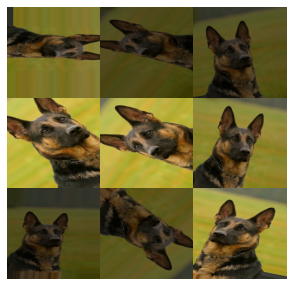

In [39]:
img = load_img(os.path.join(IMAGE_FOLDER_PATH,TrainList_df['NomImage'][8400]))

# For processing, we are converting the image(s) to an array
data = img_to_array(img)

# Expanding dimension to one sample
samples = np.expand_dims(data, 0)

# Creating an iterator for data augmentation
it = train_datagen_1.flow(samples, batch_size=1)

plt.figure(figsize=(5, 5))
# Preparing the Samples and Plot for displaying output
for i in range(9):
  # preparing the subplot
  plt.subplot(330 + 1 + i)
  # generating images in batches
  batch = it.next()
  plt.axis('off')
  plt.imshow(batch[0],aspect='auto')

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

# Ré-utilisation d'un modèle pré-entraîné VGG16 (Transfer Learning):

Définition d'une fonction de construction d'un modèle avec un transfert learning

In [30]:
def build_model_from_transfert_learning(model_name='vit_b16'):

#paramètres:
#padding: valid/same
#size: 256/512
#dropout_regularization: True/False
    
    # Charger ViT/B-16 pré-entraîné sur ImageNet2012

    vit_model = vit.vit_b16(
        image_size = IMAGE_WIDTH,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NB_CLASSES)
      
    if model_name == 'vit_b32' :
      vit_model = vit.vit_b32(
        image_size = IMAGE_WIDTH,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NB_CLASSES)
      

    if model_name == 'vit_l16' :
      vit_model = vit.vit_l16(
        image_size = IMAGE_WIDTH,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NB_CLASSES)
      
    if model_name == 'vit_l32' :
      vit_model = vit.vit_l32(
        image_size = IMAGE_WIDTH,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = NB_CLASSES)



    model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(120, 'softmax')
    ],
    name = 'vision_transformer')

    if model_name == 'vit_l16' or model_name == 'vit_l32':
      model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dense(120, 'softmax')
      ],
      name = 'vision_transformer')


    return model
  

Définition d'une fonction pour fitter et grapher les performances du modèle.

In [31]:
def fit_test_plot_model(nom_model, model_ViT, epochs,train_generator,validation_generator,test_generator):

    #categorical_crossentropy
    model_ViT.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )


    file_name = "drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_{}.h5".format(nom_model)


    checkpoint = keras.callbacks.ModelCheckpoint(
        file_name,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='auto',
        save_weights_only=True
    )

    

    earlystop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.001,
        patience=6,
        verbose=1,
        mode='auto'
    )

    reduceLR = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1, 
        mode='auto'
    )

    callbacks = [checkpoint,earlystop, reduceLR]

    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
    
    fitted_model = model_ViT.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch = STEP_SIZE_TRAIN,
        validation_data = validation_generator,
        validation_steps = STEP_SIZE_VALID,
        callbacks=callbacks,
        verbose = 2
    )
    
    #Afficher le model summary
    print(model_ViT.summary())
    

    #ax.axhline(y=mean_baseline, color="lightcoral", linestyle="dashed")

    #Plot the training history
    plt.figure(figsize=(12, 5))
    plt.plot(fitted_model.history['accuracy'], color='r')
    plt.plot(fitted_model.history['val_accuracy'], color='b')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'])
    plt.show()
    
    #Plot the loss history
    plt.figure(figsize=(12, 5))
    plt.plot(fitted_model.history['loss'], color='r')
    plt.plot(fitted_model.history['val_loss'], color='b')
    plt.title('Model Loss')
    plt.ylabel('LDroposs')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'])
    plt.show()
    
    test_loss, test_acc = model_ViT.evaluate(test_generator, steps= STEP_SIZE_TEST, verbose=2)

    print('\nTest accuracy:', test_acc)
    print('\nTest Loss:', test_loss)

    #model_ViT.save("drive/MyDrive/Colab Notebooks/"+file_name, include_optimizer=True)

Création d'un modèle Vit B16 et entrainement:

347512832/347502902 [==============================] - 39s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.08369, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B16.h5
374/374 - 342s - loss: 2.9806 - accuracy: 0.3188 - val_loss: 1.0837 - val_accuracy: 0.6950 - lr: 1.0000e-04 - 342s/epoch - 915ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.08369 to 0.94835, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B16.h5
374/374 - 317s - loss: 1.3296 - accuracy: 0.6228 - val_loss: 0.9484 - val_accuracy: 0.7297 - lr: 1.0000e-04 - 317s/epoch - 846ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.94835 to 0.88682, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B16.h5
374/374 - 317s - loss: 0.9953 - accuracy: 0.7130 - val_loss: 0.8868 - val_accuracy: 0.7393 - lr: 1.0000e-04 - 317s/epoch - 847ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.88682 to 0.81237, saving model to drive/MyDrive/Colab 

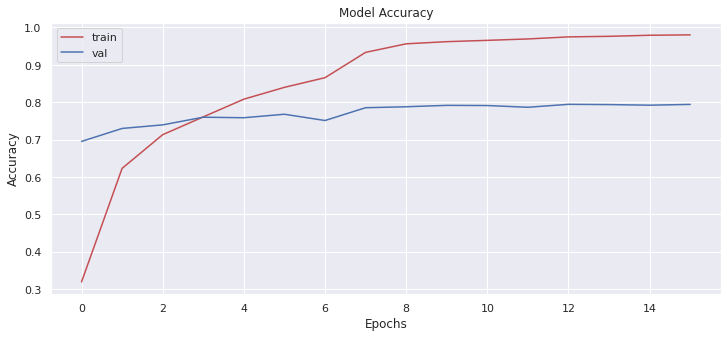

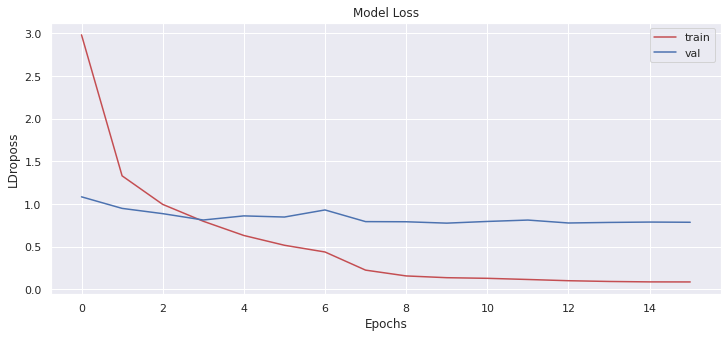

134/134 - 35s - loss: 0.6205 - accuracy: 0.8263 - 35s/epoch - 258ms/step

Test accuracy: 0.8262593150138855

Test Loss: 0.6205108165740967


In [37]:
ViT_B16_model=build_model_from_transfert_learning()
fit_test_plot_model('model_transfert_learning_B16', ViT_B16_model, NB_EPOCH,train_generator_1,validation_generator_1,test_generator_1)

Création d'un modèle Vit B32 et entrainement:

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


353263616/353253686 [==============================] - 29s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Epoch 1/100

Epoch 1: val_loss improved from inf to 2.22167, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B32.h5
374/374 - 211s - loss: 3.7531 - accuracy: 0.1618 - val_loss: 2.2217 - val_accuracy: 0.4345 - lr: 1.0000e-04 - 211s/epoch - 565ms/step
Epoch 2/100

Epoch 2: val_loss improved from 2.22167 to 1.53958, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B32.h5
374/374 - 195s - loss: 2.2021 - accuracy: 0.4225 - val_loss: 1.5396 - val_accuracy: 0.5739 - lr: 1.0000e-04 - 195s/epoch - 520ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.53958 to 1.28822, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B32.h5
374/374 - 193s - loss: 1.8603 - accuracy: 0.4972 - val_loss: 1.2882 - val_accuracy: 0.6315 - lr: 1.0000e-04 - 193s/epoch - 516ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.28822 to 1.19494, saving model to drive/MyDrive/Colab 

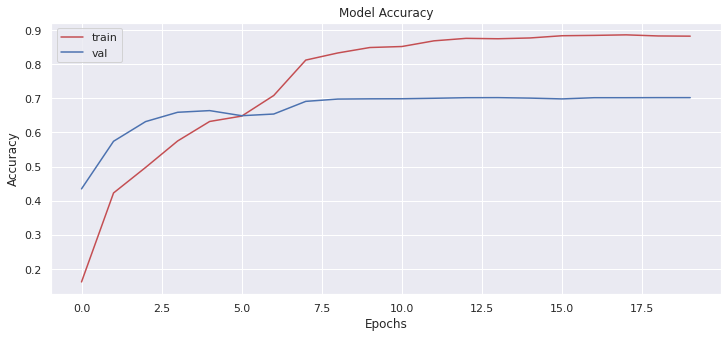

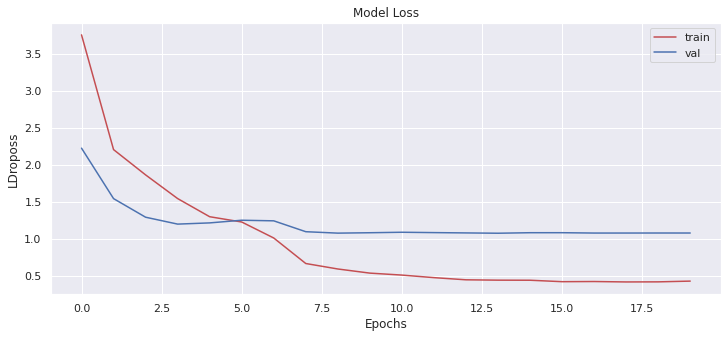

134/134 - 15s - loss: 0.9651 - accuracy: 0.7255 - 15s/epoch - 114ms/step

Test accuracy: 0.7255130410194397

Test Loss: 0.9650641083717346


In [44]:
ViT_B32_model=build_model_from_transfert_learning('vit_b32')
fit_test_plot_model('model_transfert_learning_B32', ViT_B32_model, NB_EPOCH,train_generator_1,validation_generator_1,test_generator_1)

Création d'un modèle Vit B32 et entrainement sans data-augmentation:

347512832/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


353263616/353253686 [==============================] - 4s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.22769, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B32_No_Data_Augmentation.h5
374/374 - 125s - loss: 2.3879 - accuracy: 0.4537 - val_loss: 1.2277 - val_accuracy: 0.6646 - lr: 1.0000e-04 - 125s/epoch - 335ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.22769 to 1.05283, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B32_No_Data_Augmentation.h5
374/374 - 99s - loss: 0.8619 - accuracy: 0.7566 - val_loss: 1.0528 - val_accuracy: 0.7059 - lr: 1.0000e-04 - 99s/epoch - 265ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.05283
374/374 - 96s - loss: 0.4635 - accuracy: 0.8642 - val_loss: 1.1914 - val_accuracy: 0.6814 - lr: 1.0000e-04 - 96s/epoch - 257ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.05283
374/374 - 96s - loss: 0.2922 - accuracy: 0.9107 - val_loss: 1.1769 - val_accuracy: 0.7022 - lr: 1.0000e-04 - 9

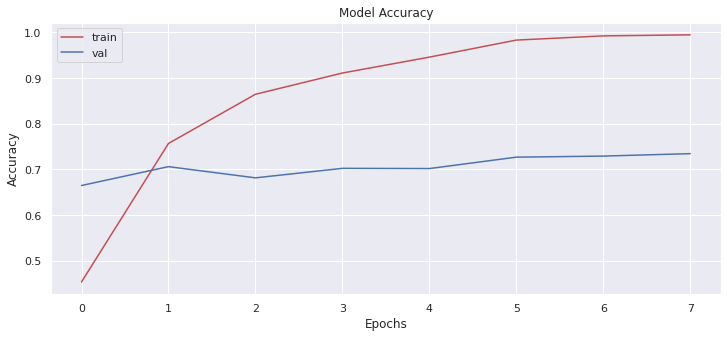

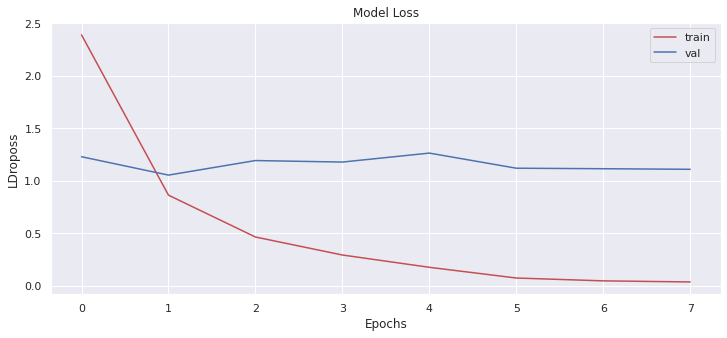

134/134 - 16s - loss: 0.9078 - accuracy: 0.7565 - 16s/epoch - 120ms/step

Test accuracy: 0.7565298676490784

Test Loss: 0.9077611565589905


In [32]:
ViT_B32_model_No_Data_Augmentation=build_model_from_transfert_learning('vit_b32')
fit_test_plot_model('model_transfert_learning_B32_No_Data_Augmentation', ViT_B32_model_No_Data_Augmentation, NB_EPOCH,train_generator_2,validation_generator_1,test_generator_1)

Création d'un modèle Vit B16 et entrainement sans data-augmentation:

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.86137, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B16_No_Data_Augmentation.h5
374/374 - 332s - loss: 1.5984 - accuracy: 0.6338 - val_loss: 0.8614 - val_accuracy: 0.7593 - lr: 1.0000e-04 - 332s/epoch - 887ms/step
Epoch 2/100

Epoch 2: val_loss improved from 0.86137 to 0.78674, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B16_No_Data_Augmentation.h5
374/374 - 317s - loss: 0.4745 - accuracy: 0.8569 - val_loss: 0.7867 - val_accuracy: 0.7812 - lr: 1.0000e-04 - 317s/epoch - 848ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.78674 to 0.76448, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_B16_No_Data_Augmentation.h5
374/374 - 317s - loss: 0.2471 - accuracy: 0.9226 - val_loss: 0.7645 - val_accuracy: 0.7908 - lr: 1.0000e-04 - 317s/epoch - 848ms/step
Epoch 4/100

Epoch 4: val_loss did not

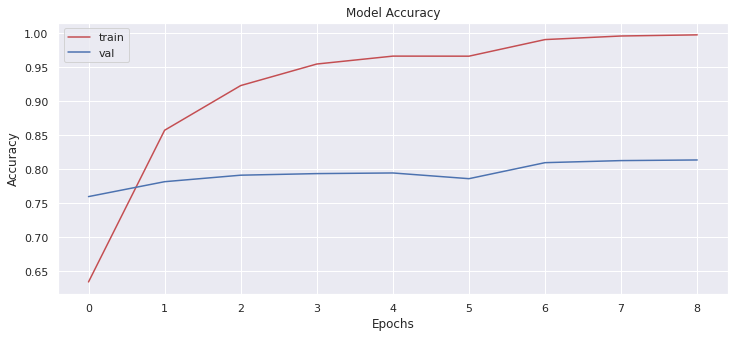

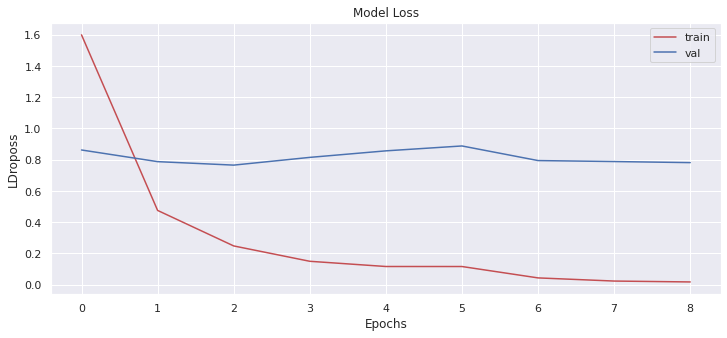

134/134 - 35s - loss: 0.6063 - accuracy: 0.8386 - 35s/epoch - 258ms/step

Test accuracy: 0.8386194109916687

Test Loss: 0.6062737107276917


In [39]:
ViT_B16_model_No_Data_Augmentation=build_model_from_transfert_learning()
fit_test_plot_model('model_transfert_learning_B16_No_Data_Augmentation', ViT_B16_model_No_Data_Augmentation, NB_EPOCH,train_generator_2,validation_generator_1,test_generator_1)

Création d'un modèle Vit L16 et entrainement:

347512832/347502902 [==============================] - 53s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


1219002368/1218991142 [==============================] - 41s 0us/step
Epoch 1/100

Epoch 1: val_loss improved from inf to 4.83607, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L16.h5
1499/1499 - 1153s - loss: 4.8513 - accuracy: 0.0073 - val_loss: 4.8361 - val_accuracy: 0.0114 - lr: 1.0000e-04 - 1153s/epoch - 769ms/step
Epoch 2/100

Epoch 2: val_loss improved from 4.83607 to 4.79900, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L16.h5
1499/1499 - 1093s - loss: 4.8215 - accuracy: 0.0079 - val_loss: 4.7990 - val_accuracy: 0.0194 - lr: 1.0000e-04 - 1093s/epoch - 729ms/step
Epoch 3/100

Epoch 3: val_loss improved from 4.79900 to 4.78953, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L16.h5
1499/1499 - 1094s - loss: 4.7932 - accuracy: 0.0086 - val_loss: 4.7895 - val_accuracy: 0.0040 - lr: 1.0000e-04 - 1094s/epoch - 730ms/step
Epoch 4/100

Epoch 

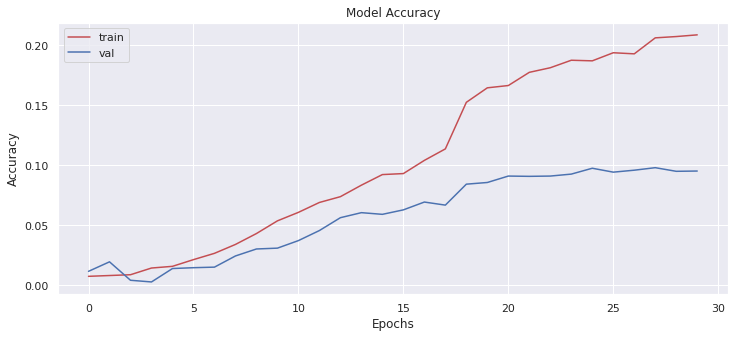

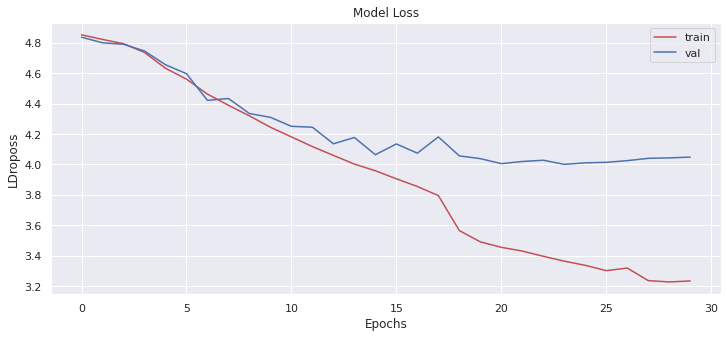

536/536 - 123s - loss: 3.8220 - accuracy: 0.1532 - 123s/epoch - 229ms/step

Test accuracy: 0.15321828424930573

Test Loss: 3.8219618797302246


In [32]:
ViT_L16_model=build_model_from_transfert_learning('vit_l16')
fit_test_plot_model('model_transfert_learning_L16', ViT_L16_model, NB_EPOCH,train_generator_1,validation_generator_1,test_generator_1)

Création d'un modèle Vit L16 et entrainement sans data-augmentation:

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.34811, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L16_No_Data_Augmentation.h5
1499/1499 - 1121s - loss: 1.8341 - accuracy: 0.5229 - val_loss: 1.3481 - val_accuracy: 0.6285 - lr: 1.0000e-04 - 1121s/epoch - 748ms/step
Epoch 2/100

Epoch 2: val_loss improved from 1.34811 to 1.17594, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L16_No_Data_Augmentation.h5
1499/1499 - 1094s - loss: 0.8957 - accuracy: 0.7288 - val_loss: 1.1759 - val_accuracy: 0.6630 - lr: 1.0000e-04 - 1094s/epoch - 730ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.17594
1499/1499 - 1085s - loss: 0.5590 - accuracy: 0.8262 - val_loss: 1.8682 - val_accuracy: 0.5679 - lr: 1.0000e-04 - 1085s/epoch - 724ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.17594
1499/1499 - 1085s - loss: 0.4394 - accuracy: 0.8623 - val_loss: 1.8089 - val_accuracy: 0.5972 

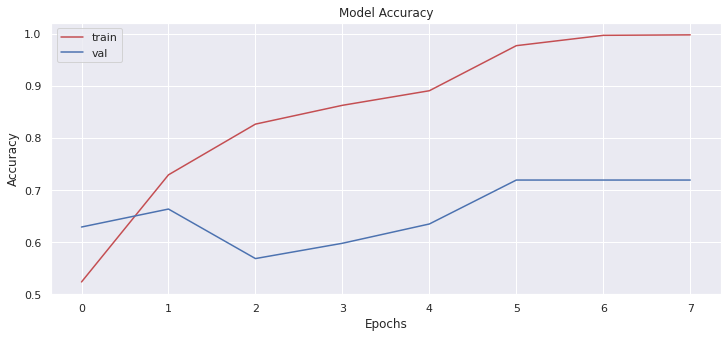

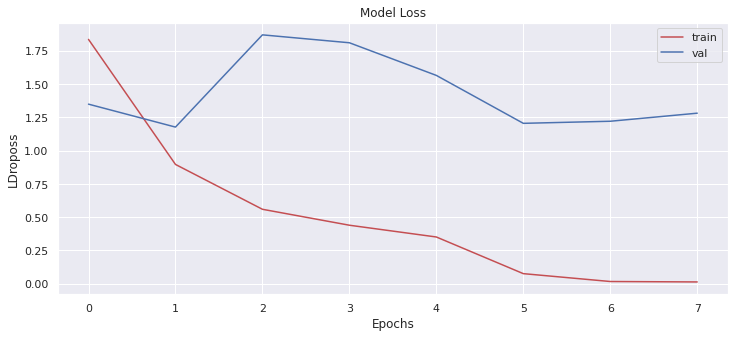

536/536 - 123s - loss: 1.0889 - accuracy: 0.7458 - 123s/epoch - 230ms/step

Test accuracy: 0.7458022236824036

Test Loss: 1.088889479637146


In [33]:
ViT_L16_model_No_Data_Augmentation=build_model_from_transfert_learning('vit_l16')
fit_test_plot_model('model_transfert_learning_L16_No_Data_Augmentation', ViT_L16_model_No_Data_Augmentation, NB_EPOCH,train_generator_2,validation_generator_1,test_generator_1)

Création d'un modèle Vit L32 et entrainement:

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,
/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Epoch 1/100

Epoch 1: val_loss improved from inf to 3.86413, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L32.h5
1499/1499 - 428s - loss: 4.5919 - accuracy: 0.0283 - val_loss: 3.8641 - val_accuracy: 0.0889 - lr: 1.0000e-04 - 428s/epoch - 286ms/step
Epoch 2/100

Epoch 2: val_loss improved from 3.86413 to 2.34509, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L32.h5
1499/1499 - 396s - loss: 2.9407 - accuracy: 0.2606 - val_loss: 2.3451 - val_accuracy: 0.3864 - lr: 1.0000e-04 - 396s/epoch - 264ms/step
Epoch 3/100

Epoch 3: val_loss improved from 2.34509 to 1.63348, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L32.h5
1499/1499 - 396s - loss: 1.9946 - accuracy: 0.4508 - val_loss: 1.6335 - val_accuracy: 0.5424 - lr: 1.0000e-04 - 396s/epoch - 264ms/step
Epoch 4/100

Epoch 4: val_loss improved from 1.63348 to 1.57030, saving model to drive/MyDrive/

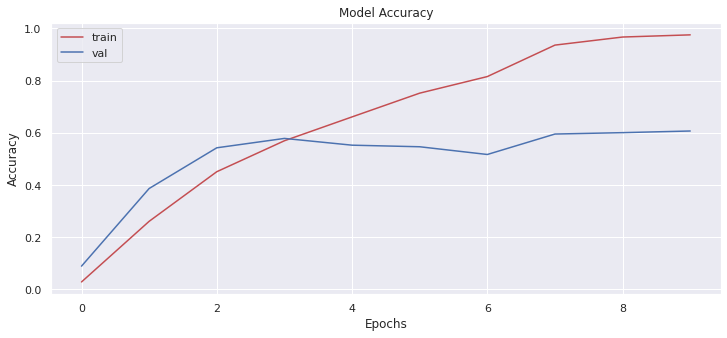

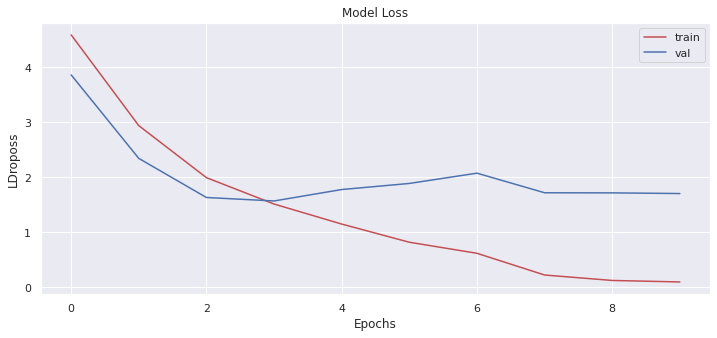

536/536 - 49s - loss: 1.5168 - accuracy: 0.6425 - 49s/epoch - 92ms/step

Test accuracy: 0.6424906849861145

Test Loss: 1.5168300867080688


In [48]:
ViT_L32_model=build_model_from_transfert_learning('vit_l32')
fit_test_plot_model('model_transfert_learning_L32', ViT_L32_model, NB_EPOCH,train_generator_1,validation_generator_1,test_generator_1)

Création d'un modèle Vit L32 et entrainement sans data augmentation:

/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  UserWarning,


1226670080/1226658854 [==============================] - 17s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


Epoch 1/100

Epoch 1: val_loss improved from inf to 1.14999, saving model to drive/MyDrive/Colab Notebooks/save_dogs_deep_learning_model_transfert_learning_L32_No_Data_Augmentation.h5
1499/1499 - 424s - loss: 1.7262 - accuracy: 0.5629 - val_loss: 1.1500 - val_accuracy: 0.6919 - lr: 1.0000e-04 - 424s/epoch - 283ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 1.14999
1499/1499 - 385s - loss: 0.7299 - accuracy: 0.7892 - val_loss: 1.2333 - val_accuracy: 0.6873 - lr: 1.0000e-04 - 385s/epoch - 257ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 1.14999
1499/1499 - 385s - loss: 0.4123 - accuracy: 0.8774 - val_loss: 1.6684 - val_accuracy: 0.6245 - lr: 1.0000e-04 - 385s/epoch - 257ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 1.14999

Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
1499/1499 - 385s - loss: 0.3048 - accuracy: 0.9096 - val_loss: 1.7067 - val_accuracy: 0.6164 - lr: 1.0000e-04 - 385s/epoch - 257ms/step
Epoch 5/100

Ep

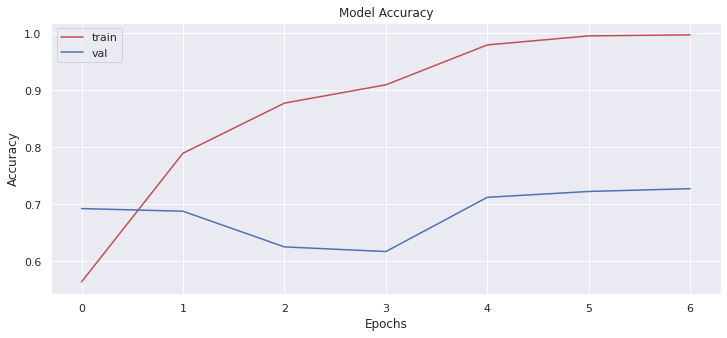

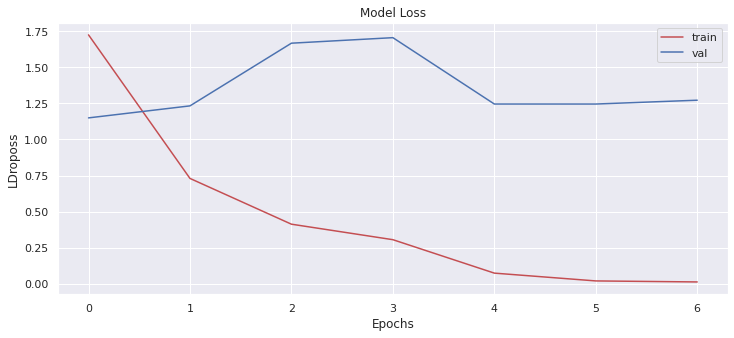

536/536 - 49s - loss: 1.2252 - accuracy: 0.7297 - 49s/epoch - 92ms/step

Test accuracy: 0.7297108173370361

Test Loss: 1.2252163887023926


In [47]:
ViT_L32_model_No_Data_Augmentation=build_model_from_transfert_learning('vit_l32')
fit_test_plot_model('model_transfert_learning_L32_No_Data_Augmentation', ViT_L32_model_No_Data_Augmentation, NB_EPOCH,train_generator_2,validation_generator_1,test_generator_1)

Je serialise le tableau des labels des différentes classes pour décoder les prédictions ensuite:

In [42]:
label_map = (train_generator_1.class_indices)

In [43]:
import pickle
f=open('drive/MyDrive/Colab Notebooks/label_map.txt','wb')  #opened the file in write and binary mode 
pickle.dump(label_map,f) #dumping the content in the variable 'content' into the file
f.close() #closing the file